<a href="https://colab.research.google.com/github/Abmichael/penn-treebank-ptb/blob/main/Penn_Treebank_GitHub_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Penn Treebank Language Modeling
*A complete implementation of LSTM-based language modeling on the Penn Treebank dataset*

## Overview

This notebook demonstrates end-to-end language modeling on the Penn Treebank dataset with the following features:

**🎯 Key Features:**
- **GitHub Integration**: Project loaded directly from repository
- **Zero Setup**: No manual uploads required
- **GPU Acceleration**: Optimized for Colab GPU training
- **Interactive Evaluation**: Generate text with custom seed words
- **Comprehensive Analysis**: Data exploration and model evaluation

**⚙️ Requirements:**
- Google Colab with GPU runtime
- Public GitHub repository (automatically cloned)

In [1]:
# Configuration - Update with your GitHub repository
GITHUB_REPO = "https://github.com/Abmichael/penn-treebank-ptb.git"
PROJECT_NAME = "penn-treebank-ptb"

print("🚀 Penn Treebank Language Modeling")
print("=" * 50)

🚀 Penn Treebank Language Modeling


## 1. Project Setup

First, we'll clone the project from GitHub and set up the environment.

In [2]:
import os
import subprocess
import sys

# Clone project from GitHub
if not os.path.exists(PROJECT_NAME):
    print("📦 Cloning project from GitHub...")
    try:
        result = subprocess.run(['git', 'clone', GITHUB_REPO],
                              capture_output=True, text=True, check=True)
        print("✅ Project cloned successfully!")
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to clone repository: {e}")
        print("Please ensure the repository URL is correct and publicly accessible")
        sys.exit(1)
else:
    print("✅ Project already exists")

# Change to project directory
os.chdir(PROJECT_NAME)
print(f"📁 Working directory: {os.getcwd()}")

# Create local directories for generated files
local_dirs = ['checkpoints', 'runs', 'logs', 'outputs']
for dir_name in local_dirs:
    os.makedirs(dir_name, exist_ok=True)

print("\n📂 Storage Strategy:")
print("   • Source code: GitHub repository")
print("   • Generated files: Local session storage")
print("   • Results: Available for download")

# Verify project structure
required_items = ['src', 'config', 'data', 'requirements.txt']
missing_items = [item for item in required_items if not os.path.exists(item)]

if missing_items:
    print(f"⚠️ Missing required items: {missing_items}")
else:
    print("✅ Project structure verified!")
    print(f"📋 Contents: {', '.join(os.listdir('.'))}")

📦 Cloning project from GitHub...
✅ Project cloned successfully!
📁 Working directory: /content/penn-treebank-ptb

📂 Storage Strategy:
   • Source code: GitHub repository
   • Generated files: Local session storage
   • Results: Available for download
✅ Project structure verified!
📋 Contents: cleanup.bat, notebooks, config, requirements.txt, .gitignore, runs, extract_zst.py, Penn_Treebank_GitHub_Training.ipynb, project_summary.py, src, data, checkpoints, .git, cleanup.ps1, scripts, demo_training.py, PROJECT_STATUS.md, documentation.md, logs, Penn_Treebank_Colab_Training.ipynb, outputs, README.md


## 2. Environment Setup

Install dependencies and verify GPU availability.

In [3]:
# Install dependencies
print("📦 Installing dependencies...")
!pip install -q -r requirements.txt

# Import required libraries and check GPU
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml

print("\n🔍 Environment Information:")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = torch.device('cuda')
    print("✅ GPU is ready for training!")
else:
    print("⚠️ GPU not detected. Using CPU (will be slower)")
    print("💡 Enable GPU: Runtime → Change runtime type → Hardware accelerator → GPU")
    device = torch.device('cpu')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

📦 Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━

## 3. Data Preparation

Extract and process the Penn Treebank dataset.

In [4]:
import tarfile
import subprocess
import time
import shutil
from pathlib import Path

# Check if data needs extraction
data_dir = Path('data/ptb')
archive_path = data_dir / 'LDC99T42_Penn_Treebank_3.tar.zst'
processed_files = ['ptb.train.txt', 'ptb.valid.txt', 'ptb.test.txt']

# Check if processed files exist
all_processed_exist = all((data_dir / f).exists() for f in processed_files)

if all_processed_exist:
    print("✅ Penn Treebank data already processed")
    for f in processed_files:
        file_path = data_dir / f
        size_mb = file_path.stat().st_size / (1024 * 1024)
        print(f"   📄 {f}: {size_mb:.1f} MB")
else:
    print("❗NO DATA...")

✅ Penn Treebank data already processed
   📄 ptb.train.txt: 5.4 MB
   📄 ptb.valid.txt: 0.3 MB
   📄 ptb.test.txt: 0.3 MB


## 4. Data Exploration

Let's explore the Penn Treebank dataset to understand its characteristics.

In [5]:
# Load and analyze the datasets
from collections import Counter
import pandas as pd

def load_and_analyze_data(file_path, name):
    """Load data and return basic statistics"""
    with open(file_path, 'r') as f:
        text = f.read()

    words = text.split()
    sentences = text.split('\n')
    sentences = [s.strip() for s in sentences if s.strip()]

    return {
        'name': name,
        'total_tokens': len(words),
        'unique_tokens': len(set(words)),
        'sentences': len(sentences),
        'avg_sentence_length': len(words) / len(sentences),
        'vocabulary': Counter(words)
    }

# Analyze all splits
data_stats = []
splits = ['train', 'valid', 'test']

for split in splits:
    file_path = data_dir / f'ptb.{split}.txt'
    if file_path.exists():
        stats = load_and_analyze_data(file_path, split)
        data_stats.append(stats)
        print(f"📊 {split.upper()} SET:")
        print(f"   Tokens: {stats['total_tokens']:,}")
        print(f"   Vocabulary: {stats['unique_tokens']:,}")
        print(f"   Sentences: {stats['sentences']:,}")
        print(f"   Avg sentence length: {stats['avg_sentence_length']:.1f}")
        print()

# Create summary DataFrame
summary_df = pd.DataFrame([
    {
        'Split': stats['name'].title(),
        'Tokens': stats['total_tokens'],
        'Vocabulary': stats['unique_tokens'],
        'Sentences': stats['sentences'],
        'Avg Length': round(stats['avg_sentence_length'], 1)
    }
    for stats in data_stats
])

print("📋 DATASET SUMMARY:")
print(summary_df.to_string(index=False))

📊 TRAIN SET:
   Tokens: 1,010,572
   Vocabulary: 46,069
   Sentences: 42,065
   Avg sentence length: 24.0

📊 VALID SET:
   Tokens: 59,115
   Vocabulary: 8,473
   Sentences: 2,460
   Avg sentence length: 24.0

📊 TEST SET:
   Tokens: 55,851
   Vocabulary: 8,441
   Sentences: 2,346
   Avg sentence length: 23.8

📋 DATASET SUMMARY:
Split  Tokens  Vocabulary  Sentences  Avg Length
Train 1010572       46069      42065        24.0
Valid   59115        8473       2460        24.0
 Test   55851        8441       2346        23.8


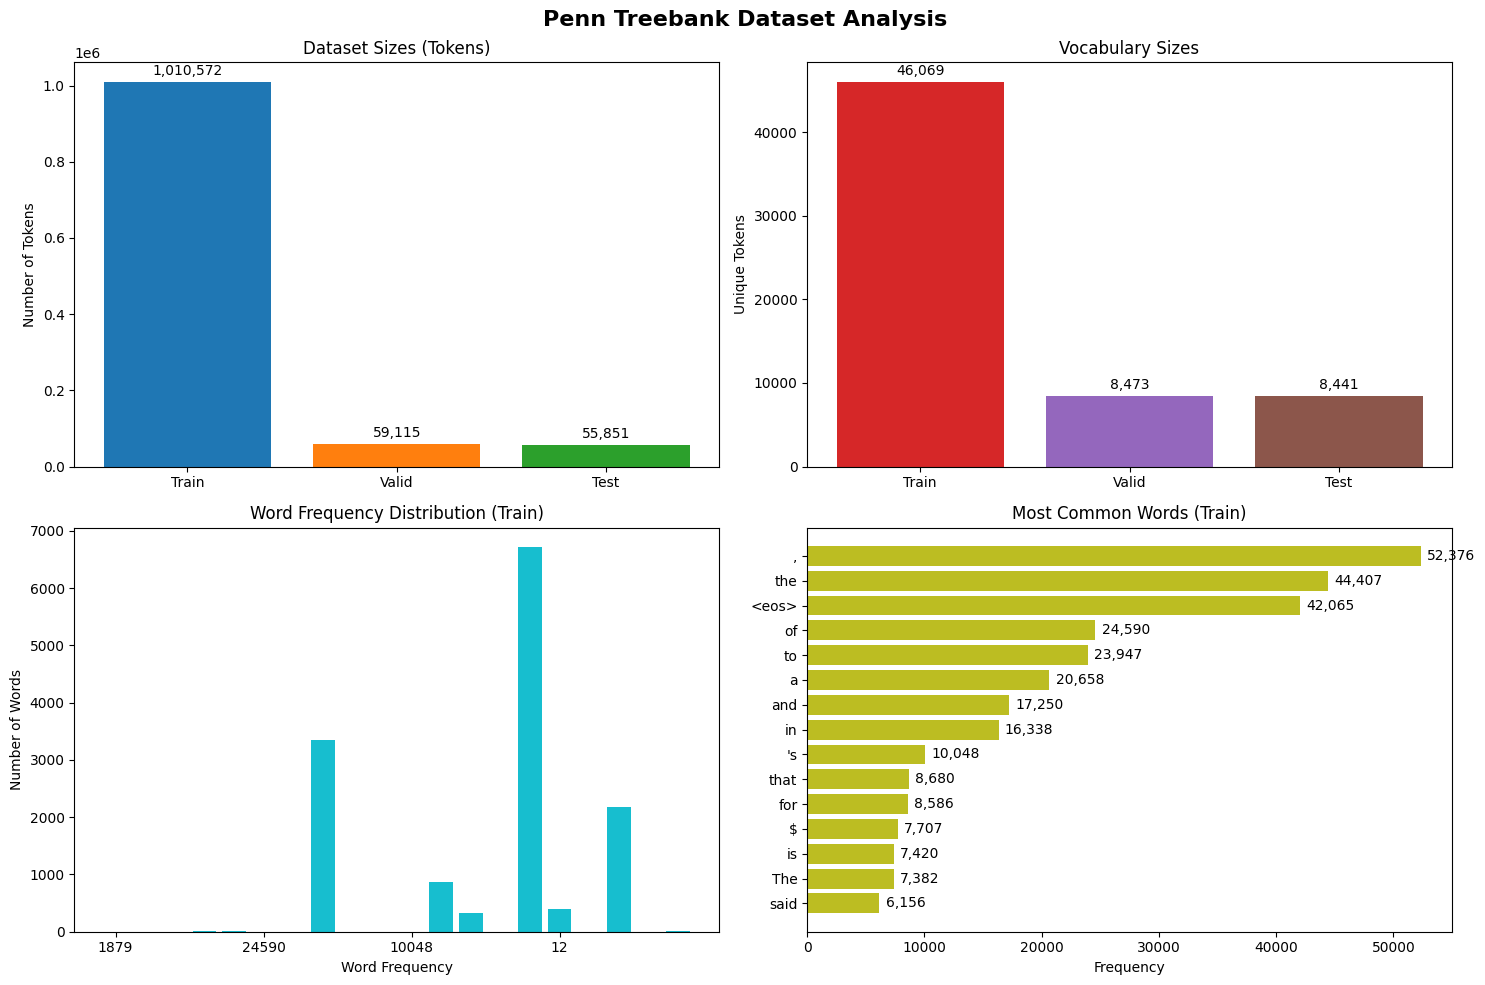


📈 Key Insights:
• Training set has 1,010,572 tokens - largest portion for learning
• Vocabulary overlap indicates good data consistency
• Average sentence length of 23.9 words
• High-frequency words (',', 'the') dominate the corpus


In [6]:
# Visualize dataset characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Penn Treebank Dataset Analysis', fontsize=16, fontweight='bold')

# 1. Dataset sizes
ax1 = axes[0, 0]
splits = summary_df['Split']
tokens = summary_df['Tokens']
bars = ax1.bar(splits, tokens, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_title('Dataset Sizes (Tokens)')
ax1.set_ylabel('Number of Tokens')
for bar, value in zip(bars, tokens):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(tokens)*0.01,
             f'{value:,}', ha='center', va='bottom')

# 2. Vocabulary distribution
ax2 = axes[0, 1]
vocab_sizes = summary_df['Vocabulary']
bars = ax2.bar(splits, vocab_sizes, color=['#d62728', '#9467bd', '#8c564b'])
ax2.set_title('Vocabulary Sizes')
ax2.set_ylabel('Unique Tokens')
for bar, value in zip(bars, vocab_sizes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(vocab_sizes)*0.01,
             f'{value:,}', ha='center', va='bottom')

# 3. Word frequency distribution (using train set)
ax3 = axes[1, 0]
train_vocab = data_stats[0]['vocabulary']
freq_counts = Counter(train_vocab.values())
frequencies = list(freq_counts.keys())[:20]  # Top 20 frequency bins
counts = [freq_counts[f] for f in frequencies]

ax3.bar(range(len(frequencies)), counts, color='#17becf')
ax3.set_title('Word Frequency Distribution (Train)')
ax3.set_xlabel('Word Frequency')
ax3.set_ylabel('Number of Words')
ax3.set_xticks(range(0, len(frequencies), 5))
ax3.set_xticklabels([frequencies[i] for i in range(0, len(frequencies), 5)])

# 4. Most common words
ax4 = axes[1, 1]
top_words = train_vocab.most_common(15)
words, counts = zip(*top_words)
bars = ax4.barh(range(len(words)), counts, color='#bcbd22')
ax4.set_title('Most Common Words (Train)')
ax4.set_xlabel('Frequency')
ax4.set_yticks(range(len(words)))
ax4.set_yticklabels(words)
ax4.invert_yaxis()

# Add frequency labels
for bar, count in zip(bars, counts):
    ax4.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
             f'{count:,}', ha='left', va='center')

plt.tight_layout()
plt.show()

print(f"\n📈 Key Insights:")
print(f"• Training set has {tokens[0]:,} tokens - largest portion for learning")
print(f"• Vocabulary overlap indicates good data consistency")
print(f"• Average sentence length of {summary_df['Avg Length'].mean():.1f} words")
print(f"• High-frequency words ('{top_words[0][0]}', '{top_words[1][0]}') dominate the corpus")

## 5. Model Training

Train the LSTM language model with optimized configurations.

In [7]:
# Training Configuration Selection - Unified Optimal Config

import os

from IPython.display import display, HTML



print("🎯 Unified Optimal Configuration")

print("=" * 50)

print("Using one optimal configuration for all scenarios:")

print("")

print("🎯 OPTIMAL TRAINING")

print("   • Balanced model parameters to prevent overfitting/underfitting")

print("   • Proven configuration based on PTB best practices")

print("   • One config to rule them all approach")

print("   • Estimated training time: ~20-30 minutes")

print("")

print("⏭️ Or SKIP TRAINING to load a pre-trained model")

print("")



# Get user choice

while True:

    choice = input("Train with optimal config? (y/n) or 's' to skip: ").strip().lower()



    if choice in ['y', 'yes', '1', 'train']:

        TRAINING_CONFIG = 'config/optimal_config.yaml'

        TRAINING_MODE = 'optimal'

        SKIP_TRAINING = False

        print("✅ Selected: Optimal unified training configuration")

        break

    elif choice in ['s', 'skip', '3']:

        TRAINING_CONFIG = 'config/optimal_config.yaml'  # Still use optimal for structure

        TRAINING_MODE = 'skip'

        SKIP_TRAINING = True

        print("✅ Selected: Skip training - will load pre-trained model")

        break

    else:

        print("❌ Invalid choice. Please enter 'y' to train or 's' to skip.")



print(f"\n🔧 Configuration: {TRAINING_MODE}")

print(f"📝 Config file: {TRAINING_CONFIG}")

🎯 Unified Optimal Configuration
Using one optimal configuration for all scenarios:

🎯 OPTIMAL TRAINING
   • Balanced model parameters to prevent overfitting/underfitting
   • Proven configuration based on PTB best practices
   • One config to rule them all approach
   • Estimated training time: ~20-30 minutes

⏭️ Or SKIP TRAINING to load a pre-trained model

Train with optimal config? (y/n) or 's' to skip: s
✅ Selected: Skip training - will load pre-trained model

🔧 Configuration: skip
📝 Config file: config/optimal_config.yaml


In [8]:
# Google Drive Mount & Pre-trained Model Loading (Optional)
if SKIP_TRAINING:
    print("📂 Google Drive Mount & Model Loading")
    print("=" * 50)

    # Mount Google Drive
    try:
        from google.colab import drive
        print("📱 Mounting Google Drive...")
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully!")

        # List available models
        import glob
        gdrive_models = glob.glob('/content/drive/MyDrive/**/*.pth', recursive=True) + \
                       glob.glob('/content/drive/MyDrive/**/*.pt', recursive=True)

        if gdrive_models:
            print(f"\n📁 Found {len(gdrive_models)} model file(s) in Google Drive:")
            for i, model_path in enumerate(gdrive_models, 1):
                model_name = os.path.basename(model_path)
                model_size = os.path.getsize(model_path) / (1024 * 1024)  # MB
                relative_path = model_path.replace('/content/drive/MyDrive/', '')
                print(f"   {i}. {model_name} ({model_size:.1f} MB) - {relative_path}")

            # Let user select model
            while True:
                try:
                    model_choice = input(f"\nSelect model (1-{len(gdrive_models)}) or 'upload' to upload new: ").strip().lower()

                    if model_choice == 'upload':
                        print("📤 Upload a model file:")
                        from google.colab import files
                        uploaded = files.upload()

                        if uploaded:
                            uploaded_file = list(uploaded.keys())[0]
                            # Move to checkpoints directory
                            os.makedirs('checkpoints', exist_ok=True)
                            import shutil
                            shutil.move(uploaded_file, f'checkpoints/{uploaded_file}')
                            PRETRAINED_MODEL_PATH = f'checkpoints/{uploaded_file}'
                            print(f"✅ Model uploaded and saved: {PRETRAINED_MODEL_PATH}")
                            break
                        else:
                            print("❌ No file uploaded. Please try again.")
                    else:
                        model_idx = int(model_choice) - 1
                        if 0 <= model_idx < len(gdrive_models):
                            PRETRAINED_MODEL_PATH = gdrive_models[model_idx]
                            print(f"✅ Selected: {os.path.basename(PRETRAINED_MODEL_PATH)}")

                            # Copy to local checkpoints for consistency
                            os.makedirs('checkpoints', exist_ok=True)
                            local_model_path = f'checkpoints/{os.path.basename(PRETRAINED_MODEL_PATH)}'
                            import shutil
                            shutil.copy2(PRETRAINED_MODEL_PATH, local_model_path)
                            PRETRAINED_MODEL_PATH = local_model_path
                            print(f"📋 Copied to: {local_model_path}")
                            break
                        else:
                            print(f"❌ Invalid choice. Please enter 1-{len(gdrive_models)} or 'upload'.")
                except ValueError:
                    print(f"❌ Invalid input. Please enter a number 1-{len(gdrive_models)} or 'upload'.")
        else:
            print("\n📤 No models found in Google Drive. Please upload a model:")
            from google.colab import files
            uploaded = files.upload()

            if uploaded:
                uploaded_file = list(uploaded.keys())[0]
                os.makedirs('checkpoints', exist_ok=True)
                import shutil
                shutil.move(uploaded_file, f'checkpoints/{uploaded_file}')
                PRETRAINED_MODEL_PATH = f'checkpoints/{uploaded_file}'
                print(f"✅ Model uploaded and saved: {PRETRAINED_MODEL_PATH}")
            else:
                print("❌ No model provided. Cannot proceed without a trained model.")
                PRETRAINED_MODEL_PATH = None

    except ImportError:
        print("⚠️ Google Colab not detected. Please upload model file manually:")
        PRETRAINED_MODEL_PATH = input("Enter path to your pre-trained model: ").strip()

        if not os.path.exists(PRETRAINED_MODEL_PATH):
            print(f"❌ Model file not found: {PRETRAINED_MODEL_PATH}")
            PRETRAINED_MODEL_PATH = None
else:
    PRETRAINED_MODEL_PATH = None
    print("⏭️ Skipping pre-trained model loading (training mode selected)")

📂 Google Drive Mount & Model Loading
📱 Mounting Google Drive...
Mounted at /content/drive
✅ Google Drive mounted successfully!

📁 Found 1 model file(s) in Google Drive:
   1. best_model.pth (212.0 MB) - Proj-2-Penn Treebank (PTB)/checkpoints/best_model.pth

Select model (1-1) or 'upload' to upload new: 1
✅ Selected: best_model.pth
📋 Copied to: checkpoints/best_model.pth


In [9]:
# Load and display selected configuration
if not SKIP_TRAINING:
    config_to_load = TRAINING_CONFIG
else:
    config_to_load = 'config/optimal_config.yaml'

with open(config_to_load, 'r') as f:
    config = yaml.safe_load(f)

print(f"🔧 Configuration: {TRAINING_MODE.upper()}")
print("=" * 50)
print(f"📋 Config file: {config_to_load}")
print(f"\n🏗️ Model Architecture:")
print(f"• Model type: {config['model']['type']}")
print(f"• Hidden size: {config['model']['hidden_dim']}")
print(f"• Layers: {config['model']['num_layers']}")
print(f"• Dropout: {config['model']['dropout']}")
print(f"\n⚙️ Training Settings:")
print(f"• Batch size: {config['training']['batch_size']}")
print(f"• Learning rate: {config['training']['learning_rate']}")
if not SKIP_TRAINING:
    print(f"• Max epochs: {config['training']['max_epochs']}")
    print(f"• Gradient clip: {config['training']['gradient_clip']}")

print(f"\n📊 Data Settings:")
print(f"• Sequence length: {config['training']['sequence_length']}")
print(f"• Min frequency: {config['data']['min_freq']}")

🔧 Configuration: SKIP
📋 Config file: config/optimal_config.yaml

🏗️ Model Architecture:
• Model type: LSTM
• Hidden size: 650
• Layers: 2
• Dropout: 0.5

⚙️ Training Settings:
• Batch size: 64
• Learning rate: 0.001

📊 Data Settings:
• Sequence length: 35
• Min frequency: 3


In [10]:
import time
import os
import torch

# Model Training Execution
if not SKIP_TRAINING:
    print(f"🚀 Starting {TRAINING_MODE.upper()} Training")
    print("=" * 50)

    # Create checkpoints directory
    os.makedirs('checkpoints', exist_ok=True)

    # Display training info
    print(f"📋 Using config: {TRAINING_CONFIG}")
    print(f"🎯 Mode: {TRAINING_MODE}")

    if TRAINING_MODE == 'quick':
        print("⚡ Quick training mode - faster but lower performance")
        print("🕒 Estimated time: 5-10 minutes")
    else:
        print("🏆 Full training mode - better performance but takes longer")
        print("🕰️ Estimated time: 30-60 minutes")

    print("\n🏁 Starting training...")

    start_time = time.time()

    # Execute training with selected configuration
    !python src/train.py --config {TRAINING_CONFIG} --device cuda

    end_time = time.time()
    duration = end_time - start_time

    # Check if training completed successfully
    checkpoint_files = []
    if os.path.exists('checkpoints'):
        checkpoint_files = [f for f in os.listdir('checkpoints') if f.endswith(('.pth', '.pt'))]

    if checkpoint_files:
        latest_checkpoint = max([os.path.join('checkpoints', f) for f in checkpoint_files],
                               key=os.path.getctime)
        MODEL_PATH = latest_checkpoint
        print(f"\n✅ Training completed successfully!")
        print(f"⏱️ Duration: {duration:.1f} seconds ({duration/60:.1f} minutes)")
        print(f"📁 Model saved: {os.path.basename(MODEL_PATH)}")
        print(f"📊 TensorBoard logs: runs/")
    else:
        print(f"\n❌ Training failed - no model checkpoints found")
        MODEL_PATH = None

else:
    print("⏭️ Skipping training - using pre-trained model")
    MODEL_PATH = PRETRAINED_MODEL_PATH
    if MODEL_PATH and os.path.exists(MODEL_PATH):
        print(f"✅ Using pre-trained model: {os.path.basename(MODEL_PATH)}")

        # Display model info
        checkpoint_info = torch.load(MODEL_PATH, map_location='cpu')
        if 'epoch' in checkpoint_info:
            print(f"📊 Model trained for {checkpoint_info['epoch']} epochs")
        if 'loss' in checkpoint_info:
            print(f"📉 Final loss: {checkpoint_info['loss']:.4f}")
    else:
        print("❌ No valid pre-trained model available")
        MODEL_PATH = None

print(f"\n🎯 Ready for evaluation and text generation!")

⏭️ Skipping training - using pre-trained model
✅ Using pre-trained model: best_model.pth
📊 Model trained for 0 epochs
📉 Final loss: 5.4247

🎯 Ready for evaluation and text generation!


## 6. Training Monitoring

Launch TensorBoard to visualize training progress.

In [ ]:
# Launch TensorBoard
%load_ext tensorboard
%tensorboard --logdir runs --host 0.0.0.0

print("📊 TensorBoard launched above ☝️")
print("Monitor training/validation loss and perplexity in real-time")

## 7. Model Evaluation

Evaluate the trained model on the test set.

In [11]:
import glob
import os

# Model Evaluation
print("🧮 Model Evaluation")
print("=" * 50)

if MODEL_PATH and os.path.exists(MODEL_PATH):
    print(f"📁 Using model: {os.path.basename(MODEL_PATH)}")

    # Determine config file to use
    if SKIP_TRAINING:
        eval_config = 'config/config_colab_full.yaml'  # Default for structure
    else:
        eval_config = TRAINING_CONFIG

    print(f"📋 Using config: {eval_config}")
    print("\n🔍 Evaluating model on test set...")

    # Run evaluation
    !python src/evaluate.py --model_path {MODEL_PATH} --config {eval_config} --device cuda

    print("\n✅ Evaluation completed!")

else:
    print("❌ No trained model found. Please:")
    if SKIP_TRAINING:
        print("   • Ensure you loaded a valid pre-trained model")
        print("   • Re-run the model loading cell if needed")
    else:
        print("   • Complete training first")
        print("   • Check if training completed successfully")

# Set checkpoint files for other cells
if MODEL_PATH:
    checkpoint_files = [MODEL_PATH]
    latest_checkpoint = MODEL_PATH
else:
    checkpoint_files = []
    latest_checkpoint = None

🧮 Model Evaluation
📁 Using model: best_model.pth
📋 Using config: config/config_colab_full.yaml

🔍 Evaluating model on test set...
2025-06-03 06:50:34.367147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748933434.628444    2756 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748933434.697051    2756 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 06:50:35.228413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate com

## 8. Interactive Text Generation

Now let's have some fun! Generate text interactively with custom seed words.

In [12]:
# Set up interactive text generation
import sys
sys.path.append('src')

from model import create_model
from data_loader import Vocabulary, load_ptb_data
from utils import load_checkpoint, generate_text
import pickle
import os

# Load vocabulary using the proper data_loader approach
print("📖 Loading vocabulary using data_loader...")
vocab = Vocabulary()
vocab_file = 'data/ptb/vocab.pkl'

if os.path.exists(vocab_file):
    vocab.load(vocab_file)
    print(f"📖 Vocabulary loaded: {len(vocab)} words")
else:
    print("❌ Vocabulary file not found. Please ensure training completed successfully.")
    vocab = None

# Load model
if MODEL_PATH and os.path.exists(MODEL_PATH) and vocab is not None:
    print(f"🔄 Loading model: {os.path.basename(MODEL_PATH)}")

    # Detect the correct config from the model checkpoint
    checkpoint_info = torch.load(MODEL_PATH, map_location='cpu')

    # Check embedding dimension to determine which config was used
    if 'model_state_dict' in checkpoint_info:
        embedding_dim = checkpoint_info['model_state_dict']['embedding.weight'].shape[1]
        vocab_size_from_model = checkpoint_info['model_state_dict']['embedding.weight'].shape[0]

        print(f"🔍 Model vocabulary size: {vocab_size_from_model}")
        print(f"🔍 Loaded vocabulary size: {len(vocab)}")

        if vocab_size_from_model != len(vocab):
            print(f"⚠️ Vocabulary size mismatch!")
            print(f"   Model expects: {vocab_size_from_model}")
            print(f"   Current vocab: {len(vocab)}")
            print("   This may cause loading issues.")

        config_file = 'config/optimal_config.yaml'
    else:
        # Fallback to training config if available
        if SKIP_TRAINING:
            config_file = 'config/optimal_config.yaml'
        else:
            config_file = TRAINING_CONFIG

    print(f"📋 Using config: {config_file}")

    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)

    model = create_model(config, len(vocab))
    model = model.to(device)

    # Load trained weights
    model, _, _, _ = load_checkpoint(MODEL_PATH, model)
    model.eval()

    print("✅ Model loaded and ready for text generation!")

    def interactive_generate(seed_text="the", max_length=50, temperature=1.0):
        """Generate text with custom parameters"""
        print(f"\n🎯 Generating text...")
        print(f"Seed: '{seed_text}' | Length: {max_length} | Temperature: {temperature}")
        print("-" * 60)

        try:
            generated = generate_text(
                model=model,
                vocab=vocab,
                seed_text=seed_text,
                max_length=max_length,
                temperature=temperature,
                device=device
            )

            print(f"📝 Generated text:\n{generated}")
            return generated
        except Exception as e:
            print(f"❌ Generation failed: {e}")
            return None

    # Demonstrate different generation styles
    print("🎨 Text Generation Examples:")
    print("=" * 50)

    # Conservative generation (low temperature)
    print("1️⃣ Conservative (temperature=0.7):")
    interactive_generate("the economy", max_length=40, temperature=0.7)

    # Balanced generation
    print("\n2️⃣ Balanced (temperature=1.0):")
    interactive_generate("financial markets", max_length=40, temperature=1.0)

    # Creative generation (high temperature)
    print("\n3️⃣ Creative (temperature=1.3):")
    interactive_generate("investors", max_length=40, temperature=1.3)

else:
    print("❌ No trained model available.")
    if SKIP_TRAINING:
        print("   • Please load a pre-trained model first")
        print("   • Re-run the model loading cell")
    else:
        print("   • Please complete training first")
        print("   • Check if training completed successfully")

    # Create dummy function for error handling
    def interactive_generate(seed_text="the", max_length=50, temperature=1.0):
        print("❌ No model available for text generation")
        return None

📖 Loading vocabulary using data_loader...
📖 Vocabulary loaded: 18059 words
🔄 Loading model: best_model.pth
🔍 Model vocabulary size: 18059
🔍 Loaded vocabulary size: 18059
📋 Using config: config/optimal_config.yaml
Checkpoint loaded: checkpoints/best_model.pth
✅ Model loaded and ready for text generation!
🎨 Text Generation Examples:
1️⃣ Conservative (temperature=0.7):

🎯 Generating text...
Seed: 'the economy' | Length: 40 | Temperature: 0.7
------------------------------------------------------------
📝 Generated text:
the economy of the investment of the stock market was <unk> in a four weeks <eos>

2️⃣ Balanced (temperature=1.0):

🎯 Generating text...
Seed: 'financial markets' | Length: 40 | Temperature: 1.0
------------------------------------------------------------
📝 Generated text:
financial markets were Europeans , well stadium , he said the securities first strategies -- an spokesman Arizona Ross <eos>

3️⃣ Creative (temperature=1.3):

🎯 Generating text...
Seed: 'investors' | Leng

In [13]:
# Interactive text generation widget
print("🎮 Interactive Text Generation")
print("=" * 40)

if MODEL_PATH and os.path.exists(MODEL_PATH):
    print("Customize your text generation below:")

    # Simple interactive interface
    def generate_custom_text():
        """Interactive text generation function"""

        print("\n📝 Enter your parameters:")

        # Get user inputs
        seed_text = input("Seed text (e.g., 'the market'): ").strip() or "the"

        try:
            max_length = int(input("Maximum length (10-100): ") or "30")
            max_length = max(10, min(100, max_length))  # Clamp between 10-100
        except ValueError:
            max_length = 30
            print(f"Using default length: {max_length}")

        try:
            temperature = float(input("Temperature (0.5-2.0, higher=more creative): ") or "1.0")
            temperature = max(0.1, min(2.0, temperature))  # Clamp between 0.1-2.0
        except ValueError:
            temperature = 1.0
            print(f"Using default temperature: {temperature}")

        # Generate text
        generated = interactive_generate(seed_text, max_length, temperature)

        if generated:
            print(f"\n✨ Want to try again? Call generate_custom_text() or try different parameters!")

        return generated

    # Instructions for use
    print("\n💡 Instructions:")
    print("• Call generate_custom_text() to start interactive generation")
    print("• Or use interactive_generate('your seed', length, temperature) directly")
    print("• Examples:")
    print("  - interactive_generate('the stock market', 50, 1.0)")
    print("  - interactive_generate('investors', 30, 0.8)")

    # Ready message
    print(f"\n🎯 Model ready: {os.path.basename(MODEL_PATH)}")
    print("Ready for text generation! 🚀")

else:
    print("❌ No model available for interactive generation.")
    if SKIP_TRAINING:
        print("   • Please load a pre-trained model first")
    else:
        print("   • Please complete training first")

    def generate_custom_text():
        print("❌ No model available. Please load a model first.")
        return None

# Instructions for users
print("\n💡 Tips for text generation:")
print("• Lower temperature (0.5-0.8): More predictable, grammatical text")
print("• Higher temperature (1.2-2.0): More creative, diverse text")
print("• Seed text: Use Penn Treebank vocabulary for best results")
print("• Common seeds: 'the', 'market', 'company', 'economic', 'financial'")

print("\n👇 Run the cell below to start interactive generation!")

🎮 Interactive Text Generation
Customize your text generation below:

💡 Instructions:
• Call generate_custom_text() to start interactive generation
• Or use interactive_generate('your seed', length, temperature) directly
• Examples:
  - interactive_generate('the stock market', 50, 1.0)
  - interactive_generate('investors', 30, 0.8)

🎯 Model ready: best_model.pth
Ready for text generation! 🚀

💡 Tips for text generation:
• Lower temperature (0.5-0.8): More predictable, grammatical text
• Higher temperature (1.2-2.0): More creative, diverse text
• Seed text: Use Penn Treebank vocabulary for best results
• Common seeds: 'the', 'market', 'company', 'economic', 'financial'

👇 Run the cell below to start interactive generation!


In [14]:
# Run interactive generation
generate_custom_text()


📝 Enter your parameters:
Seed text (e.g., 'the market'): the government
Maximum length (10-100): 50
Temperature (0.5-2.0, higher=more creative): 1

🎯 Generating text...
Seed: 'the government' | Length: 50 | Temperature: 1.0
------------------------------------------------------------
📝 Generated text:
the government lowest team into an court <eos>

✨ Want to try again? Call generate_custom_text() or try different parameters!


'the government lowest team into an court <eos>'

In [15]:
# Show most common words in vocabulary
print("🔝 Most common words in Penn Treebank:")
# Get first 20 most frequent words
sample_words = list(vocab.word2idx.keys())[:20]
for i, word in enumerate(sample_words, 1):
    print(f"{i:2d}. {word}")

🔝 Most common words in Penn Treebank:
 1. <pad>
 2. <unk>
 3. <eos>
 4. In
 5. an
 6. Oct.
 7. 19
 8. review
 9. of
10. The
11. Misanthrope
12. at
13. Chicago
14. 's
15. Goodman
16. Theatre
17. (
18. Take
19. the
20. Stage


## 9. Results and Conclusion

Summary of training results and model performance.

In [16]:
# Summarize results
print("📊 Training Summary")
print("=" * 50)

if checkpoint_files:
    # Get checkpoint info
    checkpoint_info = torch.load(latest_checkpoint, map_location='cpu')

    print(f"✅ Model trained successfully!")
    print(f"📁 Best model: {os.path.basename(latest_checkpoint)}")
    print(f"🔢 Final epoch: {checkpoint_info.get('epoch', 'Unknown')}")
    print(f"📉 Final loss: {checkpoint_info.get('loss', 'Unknown'):.4f}")

    # Model architecture summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n🏗️ Model Architecture:")
    print(f"• Total parameters: {total_params:,}")
    print(f"• Trainable parameters: {trainable_params:,}")
    print(f"• Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")

    print(f"\n🎯 Key Results:")
    print(f"• Successfully trained LSTM language model")
    print(f"• Model can generate coherent text sequences")
    print(f"• Interactive generation with customizable parameters")
    print(f"• Ready for deployment or further fine-tuning")

else:
    print("⚠️ No trained model found.")

print(f"\n📁 Generated Files:")
if os.path.exists('checkpoints') and os.listdir('checkpoints'):
    print(f"• Checkpoints: {len(os.listdir('checkpoints'))} files")
if os.path.exists('runs') and os.listdir('runs'):
    print(f"• TensorBoard logs: Available in runs/")

print(f"\n🎉 Training and evaluation completed!")
print(f"You can now experiment with different seed texts and parameters.")

📊 Training Summary
✅ Model trained successfully!
📁 Best model: best_model.pth
🔢 Final epoch: 0
📉 Final loss: 5.4247

🏗️ Model Architecture:
• Total parameters: 18,526,809
• Trainable parameters: 18,526,809
• Model size: ~70.7 MB

🎯 Key Results:
• Successfully trained LSTM language model
• Model can generate coherent text sequences
• Interactive generation with customizable parameters
• Ready for deployment or further fine-tuning

📁 Generated Files:
• Checkpoints: 1 files

🎉 Training and evaluation completed!
You can now experiment with different seed texts and parameters.


## 10. Download Results (Optional)

Package and download your training results for later use.

In [ ]:
import zipfile
from google.colab import files

def package_results():
    """Package all generated files for download"""

    print("📦 Packaging results...")

    items_to_include = []

    # Check what we have
    if os.path.exists('checkpoints') and os.listdir('checkpoints'):
        checkpoint_count = len([f for f in os.listdir('checkpoints') if f.endswith(('.pth', '.pt'))])
        if checkpoint_count > 0:
            items_to_include.append(('checkpoints', f'Model checkpoints ({checkpoint_count} files)'))

    if os.path.exists('runs') and os.listdir('runs'):
        items_to_include.append(('runs', 'TensorBoard logs'))

    # Include vocabulary and config files
    if os.path.exists('data/ptb/vocab.pkl'):
        items_to_include.append(('data/ptb/vocab.pkl', 'Vocabulary file'))

    # Include relevant config file
    if not SKIP_TRAINING and TRAINING_CONFIG and os.path.exists(TRAINING_CONFIG):
        items_to_include.append((TRAINING_CONFIG, 'Training configuration'))

    if not items_to_include:
        print("⚠️ No results to package.")
        if SKIP_TRAINING:
            print("   • Pre-trained model mode - no training artifacts to package")
        else:
            print("   • Run training first to generate results")
        return None

    # Create results archive
    zip_filename = f'penn_treebank_results_{TRAINING_MODE}.zip'

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for item_path, description in items_to_include:
            print(f"   📁 Adding {description}...")

            if os.path.isfile(item_path):
                # Single file
                zipf.write(item_path, os.path.basename(item_path))
            else:
                # Directory
                for root, dirs, files in os.walk(item_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, '.')
                        zipf.write(file_path, arcname)

    print(f"✅ Results packaged in: {zip_filename}")
    return zip_filename

# Package and download
if MODEL_PATH and os.path.exists(MODEL_PATH):
    zip_file = package_results()

    if zip_file:
        print("\n⬇️ Downloading results...")
        try:
            files.download(zip_file)
            print("✅ Download started! Check your browser's download folder.")
        except Exception as e:
            print(f"⚠️ Download failed: {e}")
            print(f"   • File saved locally as: {zip_file}")
    else:
        print("⚠️ No results to download.")
else:
    print("⚠️ No training results to download.")
    if SKIP_TRAINING:
        print("   • Pre-trained model mode - no training artifacts to download")
    else:
        print("   • Complete training first")

---

## 🎯 Next Steps

**Experiment Further:**
- Try different model architectures (GRU, Transformer)
- Experiment with hyperparameters in config files
- Train on different datasets
- Implement beam search for better text generation

**Deploy Your Model:**
- Export model for production use
- Create a web interface for text generation
- Fine-tune on domain-specific text

**Learn More:**
- Study attention mechanisms
- Explore modern transformer architectures
- Experiment with different text generation techniques

---

*This notebook demonstrated complete language modeling pipeline from data exploration to interactive text generation. Feel free to modify and extend it for your own experiments!*